<a href="https://colab.research.google.com/github/hirokimituya/stock-price-analysis/blob/main/technical_analysis/%E6%A0%AA%E4%BE%A1%E5%88%86%E6%9E%90%E9%96%A2%E6%95%B0_plotly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ta-Libの代替としてpandas_taを利用している。Ta-Libの関数名を小文字にしたものがあるイメージ
!pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=fd4f39dd1014987e8cbb71a5cd33c671008eaf6851fb4cec0c162428738cb9f3
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [2]:
# Ta-Libをインストールしてimportしようとするとエラーとなるため、代わりにpandas_taを使用している（しかし、pandas_taのローソク足パターンを分析する際にしようしているため、Ta-Libをインストールする必要あり）
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

--2023-05-23 22:53:22--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-05-23 22:53:22--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://deac-riga.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-05-23 22:53:22--  http://deac-riga.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving deac-riga.d

In [3]:
!pip install yahoo_finance_api2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for yahoo_finance_api2: filename=yahoo_finance_api2-0.0.12-py3-none-any.whl size=3714 sha256=e9dc220903fa19f4cd723b28a02a6940d11607ef0cd99fdf3742685a01ba78c4
  Stored in directory: /root/.cache/pip/wheels/e2/40/e3/f3d8054a41d7d85065555037525f48f56119cafbc5fcddf427
Successfully built yahoo_finance_api2


In [4]:
# Google Colaboratoryに画像を保存できるように設定
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/MyDrive/')

In [1]:
# show_plotly関数でエラーが出たら①ランタイムを再実行して、②このセル以降を再実行する
!pip install -U numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas_datareader.data as pdr

# 株価データを取得するメソッド
def get_stock_data(code):
    """株価データを取得する

    :param code: 取得する株価データの銘柄コード
    :return: 株価データのデータフレーム
    """
    df = pdr.DataReader(f'{code}.JP', 'stooq').sort_index()
    return df

In [3]:
from yahoo_finance_api2 import share as yapi2
from yahoo_finance_api2.exceptions import YahooFinanceError
import datetime as dt
from datetime import date,timedelta
import pandas as pd

# 株価データを取得するメソッド
def get_stock_data_yapi2(code, period_type='year', period=10):
    """株価データを取得する

    :param code: 取得する株価データの銘柄コード
    :param period_type: 取得する株価データの期間の単位（例: 'year', 'month', 'week', 'day'）
    :param period: 取得する株価データの期間の数値
    :return: 株価データのデータフレーム（もし株価データが存在しない場合は、None）
    """
    if period_type == 'month':
        period_type_value = yapi2.PERIOD_TYPE_MONTH
    elif period_type == 'week':
        period_type_value = yapi2.PERIOD_TYPE_WEEK
    elif period_type == 'day':
        period_type_value = yapi2.PERIOD_TYPE_DAY
    else:
        period_type_value = yapi2.PERIOD_TYPE_YEAR

    try:
        data = yapi2.Share(f'{code}.T').get_historical(
            period_type_value,
            period,
            yapi2.FREQUENCY_TYPE_DAY,
            1
        )
    except YahooFinanceError as e:
        print(e.message)
        print(f'銘柄コード[{code}]の株価情報を取得できなかったため、スキップしました。')
        return None

    df = pd.DataFrame(data)

    try:
        # タイムスタンプをDateTime型に変更
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    except KeyError as e:
        print(e)
        print(f'銘柄コード[{code}]の株価情報を取得できなかったため、スキップしました。')
        return None

    # 日本時間へ変換
    df['Date'] = df['datetime'] + dt.timedelta(hours=9)

    # インデックスをDateカラムに設定
    df.index = pd.to_datetime(df['Date'].dt.date)

    # 不要なカラムを削除
    del df['Date'], df['datetime'], df['timestamp']

    # 各カラムの最初の文字を大文字に変換
    for col in df.columns:
        df[f'{col.capitalize()}'] = df[col]
        del df[col]

    return df

In [6]:
import plotly.graph_objs as go
import datetime as dt
import pandas as pd
import numpy as np
import pandas_ta as ta

def show_plotly(code, name, start, end=dt.date.today(), candle_stick=True, show_close=False, mas=[], ma_mode='sma', gcdc=[], bbands={}, macd=[], rsi=[], stoch=[], volume=False, cdl_patterns=[], title='', layout_height=None, yaxis_domain_raito=None, show_days_apart=3):
    """ローソク足や移動平均線のチャートを表示する

    :param code: 取得する株価データの銘柄コード
    :param name: 取得する株価データの銘柄名
    :param start: 取得する株価データの開始日
    :param end: 取得する株価データの終了日
    :param candle_stick: チャートにローソク足を表示するかどうかのブール値
    :param show_close: チャートに終値の折れ線グラフを表示するかどうかのブール値
    :param mas: チャートに移動平均線を表示するためのリスト（例: [5, 20, 60]）
    :param ma_mode: チャートに表示する移動平均線の種類を指定（例: 'sma' or 'ema' or 'wma'）
    :param gcdc: チャートの移動平均線のゴールデンクロスとデッドクロスを表示する短長の日付のリスト（例: [5, 20]）
    :param bbands: チャートにボリンジャーバンドを表示するための辞書（例: {'sma': 20, 'bbands': [1, 2]} or {'sma': 20, 'fill': True}）
    :param macd: チャートにMACDを表示するための短期／長期／シグナルの移動平均線の日数のリスト（例: [12, 26, 9]）
    :param rsi: チャートにRSIを表示するための移動平均線の日数のリスト（例: [14, 28]）
    :param stoch: チャートにスローストキャスティクスを表示するための移動平均線の日数のリスト（例: [14, 3, 3]）
    :param volume: チャートに出来高を表示するかどうか
    :param cdl_patterns: チャートのローソク足に表示するローソク足パターンの売買シグナルのリスト（利用できる値: 'marubozu', 'belthold', 'engulfing', 'harami', '3outside', '3inside'）
    :param title: チャートのタイトルを表示
    :param layout_height: チャート全体の縦の大きさ
    :param yaxis_domain_raito: 複数のチャートを表示するときの１つのチャートの表示比率
    :param show_days_apart: チャートに表示する日付間隔
    """
    # 株価データの取得
    df = get_stock_data_yapi2(code)
    close = df['Close']

    # ▼▼▼▼▼テクニカル指標の算出▼▼▼▼▼

    #　ローソク足パターン
    if cdl_patterns:
        cdldf = ta.cdl_pattern(df['Open'], df['High'], df['Low'], df['Close'], name=cdl_patterns)
        for i, cdl_name in enumerate(cdl_patterns):
            cdlseries = cdldf.iloc[:, i]
            # チャートに表示するテキスト
            df[f'{cdl_name}_text'] = cdlseries.replace({100: '買い', -100: '売り', 0: ''})
            # チャートに表示するマーカの位置を算出
            df[f'{cdl_name}_marker'] = (cdlseries / 100 * df['High']).abs().replace({0: np.nan})

    # ①移動平均線
    for ma in mas:
        df[f'ma{ma}'] = eval(f'ta.{ma_mode}')(close, ma)
    
    # ①'ゴールデンクロスとデッドクロス
    if len(mas) >= 2 and len(gcdc) == 2 and gcdc[0] in mas and gcdc[1] in mas:
        cross = df[f'ma{gcdc[0]}'] > df[f'ma{gcdc[1]}']
        cross_shift = cross.shift(1)
        temp_gc = (cross != cross_shift) & (cross == True)
        temp_dc = (cross != cross_shift) & (cross == False)
        df['gc'] = [m if g == True else np.nan for g, m in zip(temp_gc, df[f'ma{gcdc[0]}'])]
        df['dc'] = [m if d == True else np.nan for d, m in zip(temp_dc, df[f'ma{gcdc[1]}'])]
    
    # ②ボリンジャーバンド
    if bbands:
        if not mas:
            df[f'ma{bbands["sma"]}'] = ta.sma(close, bbands['sma'])
        # 辞書bbandsのキーに'fill'が存在し、値がTrueかどうか確認
        if 'fill' not in bbands or not bbands['fill']:
            for n in bbands['bbands']:
                bbands_df = ta.bbands(close, length=bbands["sma"], std=n)
                df[f'lower{n}'], df[f'upper{n}'] = bbands_df.iloc[:, 0], bbands_df.iloc[:, 2]
        else:
            bbands_df = ta.bbands(close, length=bbands["sma"], std=2)
            df['lower2'], df['upper2'] = bbands_df.iloc[:, 0], bbands_df.iloc[:, 2]
    
    # ③MACD
    if macd:
        macd_df = ta.macd(close, fast=macd[0], slow=macd[1], signal=macd[2])
        df['macd'], df['hist'], df['macd_signal'] = macd_df.iloc[:, 0], macd_df.iloc[:, 1], macd_df.iloc[:, 2]
    
    # ④RSI
    if rsi:
        for ma in rsi:
            df[f'rsi{ma}'] = ta.rsi(close, ma)
        # 補助線
        df['70'], df['30'] = [70 for _ in close], [30 for _ in close]
    
    # ⑤ストキャスティクス
    if stoch:
        stoch_df = ta.stoch(df['High'], df['Low'], close, k=stoch[0], d=stoch[1], smooth_k=stoch[2])
        df['slowK'], df['slowD'] = stoch_df.iloc[:, 0], stoch_df.iloc[:, 1]
        # 補助線
        df['80'], df['20'] = [80 for _ in close], [20 for _ in close]

    # ▲▲▲▲▲テクニカル指標の算出▲▲▲▲▲
    
    # 日付で絞り込み
    cdf = df[start:end]

    # インデックスを文字列型に変更
    cdf.index = pd.to_datetime(cdf.index).strftime('%Y/%m/%d')

    # データ定義
    data = []

    # タイトルに表示する日付を作成
    true_start = cdf.index[0]
    true_end = cdf.index[-1]

    # チャートのタイトルを作成
    title_text = f'{code} {name} | {true_start}〜{true_end}'
    title_text = f'{title_text} | {title}' if title else title_text

    # チャートに表示するために使用する変数
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'grey']
    icolor = 0  # panel=0のcolorのインデックスを表す
    yaxis = 3   # 何番目のチャートに表示するかの番号
    yaxis_domain_spacing = .005 # チャート同士の間隔比率
    legendgrouptitle = {'text': '', 'font': {'size': 14}}   # 凡例のグループタイトルの設定

    # レイアウト定義
    layout = {
        'title': {'text': title_text, 'x': 0.5},
        'xaxis': {'rangeslider': {'visible': False}},
        'yaxis1': {'title': '価格（円）', 'side': 'left', 'tickformat': ','},
        'yaxis2': {},
        'plot_bgcolor': 'light blue',
        'height': layout_height,
    }

    def add_layout(title):
        """レイアウト定義にyaxis{n}の定義を追加する

        :param title: 追加するyaxisに指定するタイトル
        """
        nonlocal layout, yaxis
        yaxis_domain_raito_local = None

        def calc_domain():
            nonlocal layout, yaxis
            domain0 = .00
            domain1 = yaxis_domain_raito_local - yaxis_domain_spacing
            for n in range(yaxis, 2, -1):
                layout[f'yaxis{n}']['domain'] = [domain0, domain1]
                if n != 3:
                    domain0 = domain1 + yaxis_domain_spacing
                    domain1 = domain0 + (yaxis_domain_raito_local - yaxis_domain_spacing)
            
            domain0 = domain1 + yaxis_domain_spacing
            domain1 = domain0 + .10
            layout['yaxis2']['domain'] = [domain0, domain1]
            layout['yaxis1']['domain'] = [domain1, 1.0]

        if yaxis == 3:
            layout['height'] = layout_height if layout_height else 800
            yaxis_domain_raito_local = yaxis_domain_raito if yaxis_domain_raito else .18
            layout['yaxis3'] = {'title': title, 'side': 'right'}
        elif yaxis == 4:
            layout['height'] = layout_height if layout_height else 875
            yaxis_domain_raito_local = yaxis_domain_raito if yaxis_domain_raito else .16
            layout['yaxis4'] = {'title': title, 'side': 'right'}
        elif yaxis == 5:
            layout['height'] = layout_height if layout_height else 950
            yaxis_domain_raito_local = yaxis_domain_raito if yaxis_domain_raito else .15
            layout['yaxis5'] = {'title': title, 'side': 'right'}
        elif yaxis == 6:
            layout['height'] = layout_height if layout_height else 1025
            yaxis_domain_raito_local = yaxis_domain_raito if yaxis_domain_raito else .14
            layout['yaxis6'] = {'title': title, 'side': 'right'}
        
        calc_domain()
        yaxis += 1

    # ▼▼▼▼▼テクニカル指標のチャートへの表示▼▼▼▼▼

    # ローソク足を表示する
    if candle_stick:
        data.append(go.Candlestick(yaxis='y1', x=cdf.index, open=cdf['Open'], high=cdf['High'], low=cdf['Low'], close=cdf['Close'], name='ローソク足',
                       increasing_line_color='#F48FB1',
                       increasing_line_width=1.0,
                       increasing_fillcolor='#F48FB1',
                       decreasing_line_color='#90bff9',
                       decreasing_line_width=1.0,
                       decreasing_fillcolor='#90bff9'))
        cdl_names = {'marubozu': '丸坊主', 'belthold': '寄付坊主／大引坊主', 'engulfing': '包み足', 'harami': 'はらみ足', '3outside': '包み上げ／包み下げ', '3inside': 'はらみ上げ／はらみ下げ'}
        for i, cdl_name in enumerate(cdl_patterns):
            data.append(go.Scatter(yaxis='y1', x=cdf.index, y=cdf[f'{cdl_name}_marker'], mode='markers+text', text=cdf[f'{cdl_name}_text'], textposition='top center', name=cdl_names[cdl_name], 
                                   marker={'size': 12, 'color': colors[i], 'opacity': 0.6},
                                   textfont={'size': 14, 'color': 'black'}))

    # 終値の折れ線グラフを表示する
    if show_close:
        data.append(go.Scatter(yaxis='y1', x=cdf.index, y=cdf['Close'], name='終値', line={'color': 'orange', 'width': 1.2}))

    # ①移動平均線
    for ma in mas:
        legendgrouptitle['text'] = '移動平均線'
        data.append(go.Scatter(yaxis='y1', legendgroup=1, legendgrouptitle=legendgrouptitle, x=cdf.index, y=cdf[f'ma{ma}'], name=f'MA({ma})', line={'color': colors[icolor], 'width': 1.2}))
        icolor += 1
    
    # ①'ゴールデンクロスとデッドクロス
    if len(mas) >= 2 and len(gcdc) == 2 and gcdc[0] in mas and gcdc[1] in mas:
        data.append(go.Scatter(yaxis='y1', legendgroup=1, legendgrouptitle=legendgrouptitle, x=cdf.index, y=cdf['gc'], name='ゴールデンクロス', opacity=0.5, mode='markers', marker={'size': 15, 'color': 'purple'}))
        data.append(go.Scatter(yaxis='y1', legendgroup=1, legendgrouptitle=legendgrouptitle, x=cdf.index, y=cdf['dc'], name='デッドクロス', opacity=0.5, mode='markers', marker={'size': 15, 'color': 'black', 'symbol': 'x'}))
    
    # ②ボリンジャーバンド
    bbands_fill_between = {}
    if bbands:
        legendgrouptitle['text'] = 'ボリンジャーバンド'
        if not mas:
            data.append(go.Scatter(yaxis='y1', legendgroup=2, legendgrouptitle=legendgrouptitle, x=cdf.index, y=cdf[f'ma{bbands["sma"]}'], name=f'MA({bbands["sma"]})', line={'color': colors[icolor], 'width': 1.2}))
            icolor += 1
        # 辞書bbandsのキーに'fill'が存在し、値がTrueかどうか確認
        if 'fill' not in bbands or not bbands['fill']:
            for n in bbands['bbands']:
                data.append(go.Scatter(yaxis='y1', legendgroup=2, legendgrouptitle=legendgrouptitle, x=cdf.index, y=cdf[f'upper{n}'], name=f'+{n}σ', line={'color': colors[icolor], 'width': 1.2}))
                data.append(go.Scatter(yaxis='y1', legendgroup=2, legendgrouptitle=legendgrouptitle, x=cdf.index, y=cdf[f'lower{n}'], name=f'−{n}σ', line={'color': colors[icolor], 'width': 1.2}))
                icolor += 1
        else:
            data.append(go.Scatter(yaxis='y1', showlegend=False, x=cdf.index, y=cdf['upper2'], name='', line={'color': 'lavender', 'width': 0}))
            data.append(go.Scatter(yaxis='y1', legendgroup=2, legendgrouptitle=legendgrouptitle, x=cdf.index, y=cdf['lower2'], name=f'±2σ', line={'color': 'lavender', 'width': 0}, fill='tonexty', fillcolor='rgba(170, 170, 170, .2)'))
            icolor += 1
    
    # ③MACD
    if macd:
        legendgrouptitle['text'] = 'MACD'
        data.append(go.Scatter(yaxis=f'y{yaxis}', legendgroup=yaxis, legendgrouptitle=legendgrouptitle, x=cdf.index, y=cdf['macd'], name=f'MACD({macd[0]}, {macd[1]})', line={'color': colors[0], 'width': 1}))
        data.append(go.Scatter(yaxis=f'y{yaxis}', legendgroup=yaxis, legendgrouptitle=legendgrouptitle, x=cdf.index, y=cdf['macd_signal'], name=f'シグナル({macd[2]})', line={'color': colors[1], 'width': 1}))
        data.append(go.Bar(yaxis=f'y{yaxis}', legendgroup=yaxis, legendgrouptitle=legendgrouptitle, x=cdf.index, y=cdf['hist'], name='ヒストグラム', marker={'color': 'slategray'}))
        add_layout('MACD')
    
    # ④RSI
    if rsi:
        legendgrouptitle['text'] = 'RSI'
        for ma, color in zip(rsi, colors):
            data.append(go.Scatter(yaxis=f'y{yaxis}', legendgroup=yaxis, legendgrouptitle=legendgrouptitle, x=cdf.index, y=cdf[f'rsi{ma}'], name=f'RSI({ma})', line={'color': color, 'width': 1}))
        # 補助線
        data.append(go.Scatter(yaxis=f'y{yaxis}', showlegend=False, hoverinfo='skip', x=cdf.index, y=cdf['30'], name='30', line={'color': 'black', 'width': 1}))
        data.append(go.Scatter(yaxis=f'y{yaxis}', showlegend=False, hoverinfo='skip', x=cdf.index, y=cdf['70'], name='70', line={'color': 'black', 'width': 1}))
        add_layout('RSI')
    
    # ⑤ストキャスティクス
    if stoch:
        legendgrouptitle['text'] = 'ストキャスティクス'
        data.append(go.Scatter(yaxis=f'y{yaxis}', legendgroup=yaxis, legendgrouptitle=legendgrouptitle, x=cdf.index, y=cdf['slowK'], name=f'Slow%K({stoch[0]}, {stoch[1]})', line={'color': colors[0], 'width': 1}))
        data.append(go.Scatter(yaxis=f'y{yaxis}', legendgroup=yaxis, legendgrouptitle=legendgrouptitle, x=cdf.index, y=cdf['slowD'], name=f'Slow%D({stoch[2]})', line={'color': colors[1], 'width': 1}))
        # 補助線
        data.append(go.Scatter(yaxis=f'y{yaxis}', showlegend=False, hoverinfo='skip', x=cdf.index, y=cdf['20'], name='20', line={'color': 'black', 'width': 1}))
        data.append(go.Scatter(yaxis=f'y{yaxis}', showlegend=False, hoverinfo='skip', x=cdf.index, y=cdf['80'], name='80', line={'color': 'black', 'width': 1}))
        add_layout('ストキャスティクス')
    
    # ▲▲▲▲▲テクニカル指標のチャートへの表示▲▲▲▲▲

    # 出来高を表示する
    if volume:
        data.append(go.Bar(yaxis=f'y{yaxis}', showlegend=False, x=cdf.index, y=cdf['Volume'], name='出来高', marker={'color': 'slategray'}))
        add_layout('出来高')

    # グラフ生成
    fig = go.Figure(data=data, layout=go.Layout(layout))

    # レイアウトを更新
    fig.update_layout({
        'xaxis': {
            # 日付を3日おきに表示するように設定
            'tickvals': cdf.index[::show_days_apart],
        },
        'legend': {
            'groupclick': 'toggleitem',
            'traceorder': 'grouped',
        }
    })

    # 複数チャートを表示するとx軸のグリッドが消えたので、グリッドを表示するように設定
    fig.update_xaxes(showgrid=True)

    # 表示
    fig.show()

    # チャートをHTMLとして保存
    # fig.write_html(f'{title_text}.html')

    # データフレームをCSVファイルに出力
    # df.to_csv(f'{title_text}.csv')

# show_plotly関数の使用例


In [8]:
show_plotly(1928, '積水ハウス', '2021-12-1', '2022-3-31', mas=[5, 25], gcdc=[5, 25])

In [9]:
show_plotly(1928, '積水ハウス', '2021-12-1', '2022-3-31', mas=[5, 25], gcdc=[5, 25], bbands={'sma': 25, 'fill': True}, macd=[12, 26, 9])

In [10]:
show_plotly(1928, '積水ハウス', '2021-12-1', '2022-3-31', mas=[5, 25], gcdc=[5, 25], bbands={'sma': 25, 'fill': True}, macd=[12, 26, 9], rsi=[14, 28])

In [11]:
show_plotly(1928, '積水ハウス', '2021-12-1', '2022-3-31', mas=[5, 25], gcdc=[5, 25], bbands={'sma': 25, 'fill': True}, macd=[12, 26, 9], rsi=[14, 28], stoch=[5, 3, 3])

In [12]:
show_plotly(1928, '積水ハウス', '2021-12-1', '2022-3-31', mas=[5, 25], gcdc=[5, 25], bbands={'sma': 25, 'fill': True}, macd=[12, 26, 9], rsi=[14, 28], stoch=[5, 3, 3], volume=True)

# Plotly以外で株価分析に使用できるライブラリ



In [13]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[*********************100%***********************]  3 of 3 completed


<Axes: xlabel='Date'>

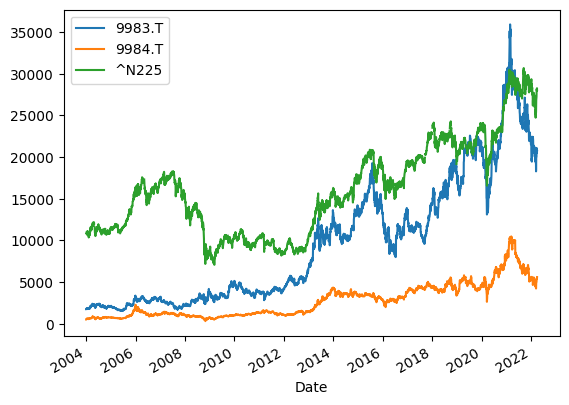

In [14]:
# 複数の銘柄の株価を取得するyfinance
import plotly.express as px
import yfinance as yf
import datetime

start = datetime.date(2004, 1, 1)
end = datetime.date(2022, 3, 31)

# 株価データ取得
# ソフトバンクグループ、ファーストリテイリング、日経平均株価
df = yf.download(['9984.T', '9983.T', '^N225'], start=start, end=end)['Adj Close']

# 調整後終値をプロット
df.plot()

In [15]:
# plotly.expressでのトレンドライン描画
import plotly.express as px
import yfinance as yf
import datetime

start = datetime.date(2004, 1, 1)
end = datetime.date(2022, 3, 31)

df = yf.download('^N225', start=start, end=end) # 日経平均
fig = px.scatter(df, x=df.index, y='Close', trendline='ols')
fig.show()

[*********************100%***********************]  1 of 1 completed


In [16]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[*********************100%***********************]  1 of 1 completed

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpjpvf_yh1/om5be_yf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjpvf_yh1/m_941g36.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96466', 'data', 'file=/tmp/tmpjpvf_yh1/om5be_yf.json', 'init=/tmp/tmpjpvf_yh1/m_941g36.json', 'output', 'file=/tmp/tmpjpvf_yh1/prophet_modelwbaqrv6a/prophet_model-20230523225818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:58:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:58:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


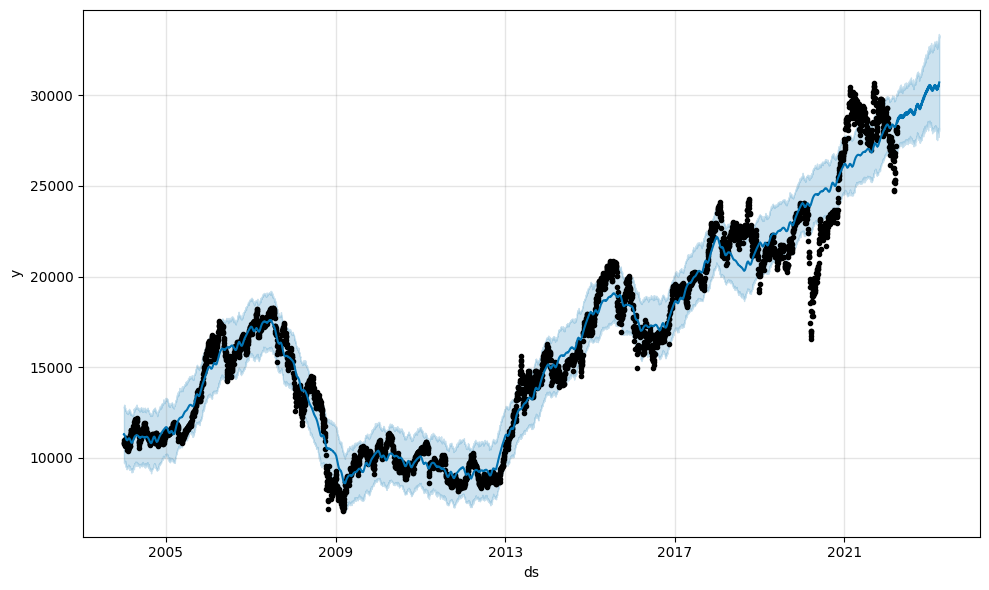

In [17]:
# 株価を予測するProphet
from prophet import Prophet
import yfinance as yf
import datetime

start = datetime.date(2004, 1, 1)
end = datetime.date(2022, 3, 31)

df = yf.download('^N225', start=start, end=end) # 日経平均

df['ds'] = df.index # dsカラムにに日付を格納
df = df.rename(columns={'Close': 'y'})  # Closeカラムの名前をyに変更

prop = Prophet()
prop.fit(df)    # データフレームをセット
future = prop.make_future_dataframe(periods=365)    # 365日の期間を設定
forecast = prop.predict(future) # 予想を実行
fig = prop.plot(forecast)   # 結果の取得と表示
fig.show()

# グランビルの法則

In [18]:
show_plotly(5401, '日本製鉄', '2020-1-1', '2022-3-31', candle_stick=False, show_close=True, mas=[200], title='グランビルの法則', show_days_apart=10, layout_height=600)

In [19]:
show_plotly(5401, '日本製鉄', '2020-1-1', '2022-3-31', candle_stick=False, show_close=True, mas=[200], ma_mode='ema', title='グランビルの法則（指数平滑移動平均線）', show_days_apart=10, layout_height=600)

In [20]:
show_plotly(7222, '日産車体', '2020-1-1', '2022-3-31', candle_stick=False, show_close=True, mas=[200], title='グランビルの法則', show_days_apart=10, layout_height=600)

# ローソク足チャート

In [21]:
show_plotly(1928, '積水ハウス', '2021-11-1', '2022-3-31', title='ローソク足チャート', cdl_patterns=['marubozu', 'belthold', 'engulfing', 'harami', '3outside', '3inside'], show_days_apart=5, layout_height=600)

In [25]:
show_plotly(2395, '新日本科学', '2023-1-1', mas=[5, 20, 60], macd=[12, 26, 9], rsi=[14, 28], show_days_apart=5)